# US Name
Estimate SO2 emission as a function of  period and others variables


# Description

- Effect of credit supply

## Variables
### Target

SO2 emission

### Features

- credit_supply
- credit_supply_long_term
- credit_supply_short_ term
- share_ big bank_loan
- share_big_loan

## Complementary information

Title: Add credit supply
Use the new variables such as credit supply in the model to interact with FYP and period
Add tfp?

# Metadata

- Key: 171_Pollution_and_Credit_Constraint
- Epic: Models
- US: Credit supply
- Task tag: #data-analysis, #credit-supply
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name**

- https://github.com/thomaspernet/pollution_credit_constraint/blob/master/01_data_preprocessing/02_transform_tables/00_credit_constraint_industry.md

**Github**

- fin_dep_pollution_baseline_industry



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json
import sys

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-3'
bucket = 'datalake-datascience'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [5]:
change_target <- function(table){
    ## Regime
    check_target <- grep("periodTRUE:tso2_mandate_c:credit_constraint", rownames(table$coef))
    
    if (length(check_target) !=0) {
    ## SOE
    rownames(table$coefficients)[check_target] <- 'credit_constraint:periodTRUE:tso2_mandate_c'
    rownames(table$beta)[check_target] <- 'credit_constraint:periodTRUE:tso2_mandate_c'
    } 
    return (table)
}

# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [6]:
db = 'environment'
table = 'fin_dep_pollution_baseline_industry'

In [7]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)',
                         'varchar(3)',
                        'varchar(14)', 'varchar(11)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [14]:
download_data = False
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalog/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT *,
    DENSE_RANK() OVER (
    ORDER BY 
      year
  ) AS trend,
  DENSE_RANK() OVER (
    ORDER BY 
      province_en, year
  ) as fe_p_t,
  DENSE_RANK() OVER (
    ORDER BY 
      province_en, ind2
  ) as fe_p_i
  
    FROM {}.{}
    WHERE so2_intensity > 0
    """.format(db, table)
    try:
        df = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
              #.assign(
              #    trend = lambda x: pd.factorize(x["year"].astype('str')
              #                         )[0] + 1
              #)
                )
    except:
        pass
    s3.download_file(
        key = full_path_filename
    )
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)
    df.head()
    

In [9]:
pd.DataFrame(schema)

,Name,Type,Comment
0,year,string,
1,period,varchar(5),
2,province_en,string,
3,cityen,string,
4,geocode4_corr,string,
...,...,...,...
95,dominated_sales_for_i,"map<double,boolean>",
96,dominated_capital_for_i,"map<double,boolean>",
97,fe_c_i,bigint,
98,fe_t_i,bigint,


## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [10]:
add_to_dic = True
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
    data = {'to_rename':[], 'to_remove':[]}
    dic_rename =  [
        {
        'old':'periodTRUE',
        'new':'\\text{period}'
        },
        {
        'old':'period',
        'new':'\\text{period}'
        },
        
        ### depd
        ###mandate
        {
        'old':'tso2\_mandate\_c',
        'new':'\\text{S02 mandate}_c'
        },
        {
        'old':'target\_reduction\_so2\_p',
        'new':'\\text{S02 mandate}_p'
        },
        {
        'old':'target\_reduction\_co2\_p',
        'new':'\\text{COD mandate}_p'
        },
        ### financial ratio
        {
        'old':'total\_asset',
        'new':'\\text{total asset}'
        },
        {
        'old':'tangible',
        'new':'\\text{tangible asset}'
        },
        {
        'old':'investment\_tot\_asset',
        'new':'\\text{investment to asset}'
        },
        {
        'old':'rd\_tot\_asset',
        'new':'\\text{rd to asset}'
        },
        {
        'old':'asset\_tangibility\_tot\_asset',
        'new':'\\text{asset tangibility}'
        },
        {
        'old':'d\_avg\_ij\_o\_city\_mandate',
        'new':'\\text{relative reduction mandate}_c'
        },
        ### ind
        {
        'old':'current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'lag\_current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'quick\_ratio',
        'new':'\\text{quick ratio}'
        },
        {
        'old':'lag\_liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'lag\_sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'cash\_tot\_asset',
        'new':'\\text{cash to asset}'
        },
        {
        'old':'cashflow\_tot\_asset',
        'new':'\\text{cashflow to asset}'
        },
        {
        'old':'cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'lag\_cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'d\_credit\_constraintBELOW',
        'new':'\\text{Fin dep}_{i}'
        },
        ## control
        {
        'old':'age + 1',
        'new':'\\text{age}'
        },
        {
        'old':'export\_to\_sale',
        'new':'\\text{export to sale}'
        },
        {
        'old':'labor\_capital',
        'new':'\\text{labor to capital}'
        },
        ### Supply demand external finance
        {
        'old':'supply\_all\_credit',
        'new':'\\text{all credit}'
        },
        {
        'old':'lag\_credit\_supply\_short\_term',
        'new':'\\text{Short term loan}_{pt}'
        },
        {
        'old':'lag\_credit\_supply',
        'new':'\\text{All loan}_{pt}'
        },
        {
        'old':'lag\_credit\_supply\_long\_term',
        'new':'\\text{Long-term loan}_{pt}'
        },
        {
        'old':'fin\_dev',
        'new':'\\text{financial development}_{pt}'
        },
        {
        'old':'credit\_constraint',
        'new':'\\text{credit constraint}'
        },
        {
        'old':'soe\_vs\_priPRIVATE',
        'new':'\\text{private}'
        },
        ## TFP
        {
        'old':'tfp\_cit',
        'new':'\\text{TFP}'
        },
        ### year
        {
        'old':'year1998',
        'new':'\\text{1998}'
        },
        {
        'old':'year1999',
        'new':'\\text{1999}'
        },
        {
        'old':'year2000',
        'new':'\\text{2000}'
        },
        {
        'old':'year2001',
        'new':'\\text{2001}'
        },
        {
        'old':'year2002',
        'new':'\\text{2002}'
        },
        {
        'old':'year2003',
        'new':'\\text{2003}'
        },
        {
        'old':'year2004',
        'new':'\\text{2004}'
        },
        {
        'old':'year2005',
        'new':'\\text{2005}'
        },
        {
        'old':'year2006',
        'new':'\\text{2006}'
        },
        {
        'old':'year2007',
        'new':'\\text{2007}'
        },
        
        
    ]
    

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [11]:
sys.path.append(os.path.join(parent_path, 'utils'))
import latex.latex_beautify as lb
#%load_ext autoreload
#%autoreload 2

In [12]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [15]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    year = relevel(as.factor(year), ref='2001'),
    period = relevel(as.factor(period), ref='FALSE'),
    polluted_d50i = relevel(as.factor(polluted_d50i), ref='BELOW'),
    polluted_d75i = relevel(as.factor(polluted_d75i), ref='BELOW'),
    polluted_d80i = relevel(as.factor(polluted_d80i), ref='BELOW'),
    polluted_d85i = relevel(as.factor(polluted_d85i), ref='BELOW'),
    polluted_d90i = relevel(as.factor(polluted_d90i), ref='BELOW'),
    polluted_d95i = relevel(as.factor(polluted_d95i), ref='BELOW'),
    polluted_mi = relevel(as.factor(polluted_mi), ref='BELOW'),
    d_avg_ij_o_city_mandate = relevel(as.factor(d_avg_ij_o_city_mandate), ref="FALSE"),
    fin_dev = 1- share_big_loan,
    lag_fin_dev = 1- lag_share_big_loan,
)

Parsed with column specification:
cols(
  .default = col_double(),
  period = col_logical(),
  province_en = col_character(),
  cityen = col_character(),
  short = col_character(),
  polluted_d50i = col_character(),
  polluted_d75i = col_character(),
  polluted_d80i = col_character(),
  polluted_d85i = col_character(),
  polluted_d90i = col_character(),
  polluted_d95i = col_character(),
  polluted_mi = col_character(),
  polluted_d50_cit = col_character(),
  polluted_d75_cit = col_character(),
  polluted_d80_cit = col_character(),
  polluted_d85_cit = col_character(),
  polluted_d90_cit = col_character(),
  polluted_d95_cit = col_character(),
  polluted_m_cit = col_character(),
  above_threshold_mandate = col_character(),
  above_average_mandate = col_character()
  # ... with 24 more columns
)
See spec(...) for full column specifications.


In [16]:
head(df_final)

year,period,province_en,cityen,geocode4_corr,tcz,spz,ind2,short,polluted_d50i,...,dominated_sales_for_i,dominated_capital_for_i,fe_c_i,fe_t_i,fe_c_t,trend,fe_p_t,fe_p_i,fin_dev,lag_fin_dev
1998,FALSE,Sichuan,Luzhou,5105,1,0,26,Raw Chemical Materials,ABOVE,...,"{0.5=false, 0.9=false, 0.75=false, 0.95=false}","{0.5=false, 0.9=false, 0.75=false, 0.95=false}",5119,14,2114,1,244,716,0.51595,0.52982
1998,FALSE,Sichuan,Nanchong,5113,1,0,15,Beverages,ABOVE,...,"{0.5=true, 0.9=true, 0.75=true, 0.95=true}","{0.5=true, 0.9=true, 0.75=true, 0.95=true}",5262,3,2184,1,244,705,0.51595,0.52982
1998,FALSE,Sichuan,Zigong,5103,1,0,20,Manufacture of Wood,BELOW,...,NA,NA,5079,8,2094,1,244,710,0.51595,0.52982
1998,FALSE,Sichuan,Panzhihua,5104,1,0,26,Raw Chemical Materials,ABOVE,...,"{0.5=true, 0.9=true, 0.75=true, 0.95=true}","{0.5=true, 0.9=true, 0.75=true, 0.95=true}",5101,14,2104,1,244,716,0.51595,0.52982
1998,FALSE,Sichuan,Deyang,5106,1,0,32,Smelting ferrous Metals,ABOVE,...,"{0.5=true, 0.9=false, 0.75=false, 0.95=false}","{0.5=true, 0.9=false, 0.75=true, 0.95=false}",5144,20,2124,1,244,722,0.51595,0.52982
1998,FALSE,Sichuan,Suining,5109,1,0,35,Machinery,BELOW,...,NA,NA,5211,23,2154,1,244,725,0.51595,0.52982


Aggregate at the province-industry-year level

In [17]:
df_agg <- df_final %>%
group_by(province_en, ind2, year, period, fe_p_i , fe_t_i , fe_p_t) %>%
summarize(
    tso2 = sum(tso2),
    tcod = sum(tcod),
    twaste_water = sum(twaste_water),
    output = sum(output),
    employment = sum(employment),
    capital = sum(capital),
    target_reduction_so2_p = max(target_reduction_so2_p),
    target_reduction_co2_p = max(target_reduction_co2_p),
    lag_credit_supply = max(lag_credit_supply),
    lag_credit_supply_long_term = max(lag_credit_supply_long_term),
    fin_dev = max(fin_dev),
    lag_fin_dev = max(lag_fin_dev),
    credit_constraint = max(credit_constraint),
) %>%
ungroup()%>%
mutate(
    year = relevel(as.factor(year), ref='2001'),
    year1 = relevel(as.factor(year), ref='2005')
)

head(df_agg)

province_en,ind2,year,period,fe_p_i,fe_t_i,fe_p_t,tso2,tcod,twaste_water,...,employment,capital,target_reduction_so2_p,target_reduction_co2_p,lag_credit_supply,lag_credit_supply_long_term,fin_dev,lag_fin_dev,credit_constraint,year1
Anhui,13,2001,FALSE,1,88,4,1398456,1431675.1,4497401,...,26970,1247712,0.23,0.65,0.67769,0.17947,0.46564,0.45456,-0.47,2001
Anhui,13,1998,FALSE,1,1,1,469673,3310501.0,1929756,...,36357,720409,0.23,0.65,0.58065,0.11785,0.38202,0.43303,-0.47,1998
Anhui,13,1999,FALSE,1,30,2,924790,1398194.0,1891661,...,34438,1180475,0.23,0.65,0.61749,0.12280,0.37900,0.38202,-0.47,1999
Anhui,13,2000,FALSE,1,59,3,1071436,1534712.0,2599504,...,32534,1226724,0.23,0.65,0.59567,0.11632,0.45456,0.37900,-0.47,2000
Anhui,13,2002,FALSE,1,116,5,531884,816333.9,2301020,...,3064,74066,0.23,0.65,0.72964,0.20348,0.46148,0.46564,-0.47,2002
Anhui,13,2003,FALSE,1,145,6,1459373,1728301.1,5968583,...,39179,1711543,0.23,0.65,0.74632,0.20580,0.46861,0.46148,-0.47,2003


## Variables Definition

1. credit_supply: Province-year supply all loans over GDP
2. credit_supply_long_term: Province-year supply long term loans over GDP
3. fin_dev: Share of non-4-SOCBs' share in credit

## Table 1:Financial development over time

$$
\begin{aligned}
\text{$S O 2_{c k t}=\alpha$ Financial Dependencies $_{k} \times \text{credit supply}_{pt} +\beta X_{c k t}+\mu_{c t}+\gamma_{k t}+\delta_{c k}+\epsilon_{c k t}$}
\end{aligned}
$$

$$
\begin{aligned}
\text{$S O 2_{c k t}=\alpha$ Financial Dependencies $_{k} \times \text{Fin.Dev}_{pt} + +\beta X_{c k t}+\mu_{c t}+\gamma_{k t}+\delta_{c k}+\epsilon_{c k t}$}
\end{aligned}
$$

1. Table 1: SO2 emission reduction, credit supply and financial development
  1. All loan interacted with credit constraint
  2. Long term loan with credit constraint
  3. Financial development with credit constraint

**Message**

* An increase of supply of credit or improvement of financial development (deregulation of banking sectors) is beneficial for the reduction of SO2 emission
  * Deregulation has a stronger effect on constraint sectors than non-constraint → backed by the theory that credit openness is more beneficial for constraint sectors

### City level

In [39]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [27]:
query = """
SELECT ind2, SUM(tso2) as sum_tso2
FROM fin_dep_pollution_baseline_industry 
WHERE year = '1998'
GROUP BY ind2
ORDER BY sum_tso2
"""
list_polluted = s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='polluted',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        )
list_polluted

,ind2,sum_tso2
0,24,795842
1,21,899680
2,23,1810115
3,42,3814904
4,18,4701939
5,39,5678475
6,30,8212386
7,16,11221820
8,19,11550535
9,41,13198392


In [40]:
%get path table
to_remove <- c(
    24, 21, 23,#, 42,18,
    33, 32, 26#, 31,17
)
## SO2
t_0 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(tso2 > 500),
            exactDOF = TRUE)

t_1 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply_long_term) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(tso2 > 500),
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(fin_dev) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_final%>% filter(tso2 > 500),
            exactDOF = TRUE)

t_3 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(
               tso2 > 500 & !(ind2 %in% to_remove)),
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply_long_term) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(tso2 > 500 & !(ind2 %in% to_remove)),
            exactDOF = TRUE)

t_5 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(fin_dev) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_final%>% filter(tso2 > 500 & !(ind2 %in% to_remove)),
            exactDOF = TRUE)
## COD
#t_3 <- felm(log(tcod) ~  
#            log(output) + log(employment) + log(capital) + 
#            log(lag_credit_supply) * credit_constraint
#           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(tcod > 0),
#            exactDOF = TRUE)

#t_4 <- felm(log(tcod) ~  
#            log(output) + log(employment) + log(capital) + 
#            log(lag_credit_supply_long_term) * credit_constraint
#           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(tcod > 0),
#            exactDOF = TRUE)

#t_5 <- felm(log(tcod) ~  
#            log(output) + log(employment) + log(capital) + 
#            log(fin_dev) * credit_constraint
#           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_final%>% filter(tcod > 0),
#            exactDOF = TRUE)
## twaste water
#t_6 <- felm(log(twaste_water) ~  
#            log(output) + log(employment) + log(capital) + 
#            log(lag_credit_supply) * credit_constraint
#           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(twaste_water > 500),
#            exactDOF = TRUE)

#t_7 <- felm(log(twaste_water) ~  
#            log(output) + log(employment) + log(capital) + 
#            log(lag_credit_supply_long_term) * credit_constraint
#           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(twaste_water > 500),
#            exactDOF = TRUE)

#t_8 <- felm(log(twaste_water) ~  
#            log(output) + log(employment) + log(capital) + 
#            log(fin_dev) * credit_constraint
#           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_final%>% filter(twaste_water > 500),
#            exactDOF = TRUE)
            
dep <- "Dependent variable: Pollution emission"
fe1 <- list(
    c("City-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"
      #, "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"
     ),
    c("Time-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"
      #, "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"
     ),
    c("City-Time", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"
      #,"Yes", "Yes", "Yes", "Yes", "Yes", "Yes"
     )
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5#, t_6, t_7, t_8
),
    title="Pollution emission, credit supply and financial development",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

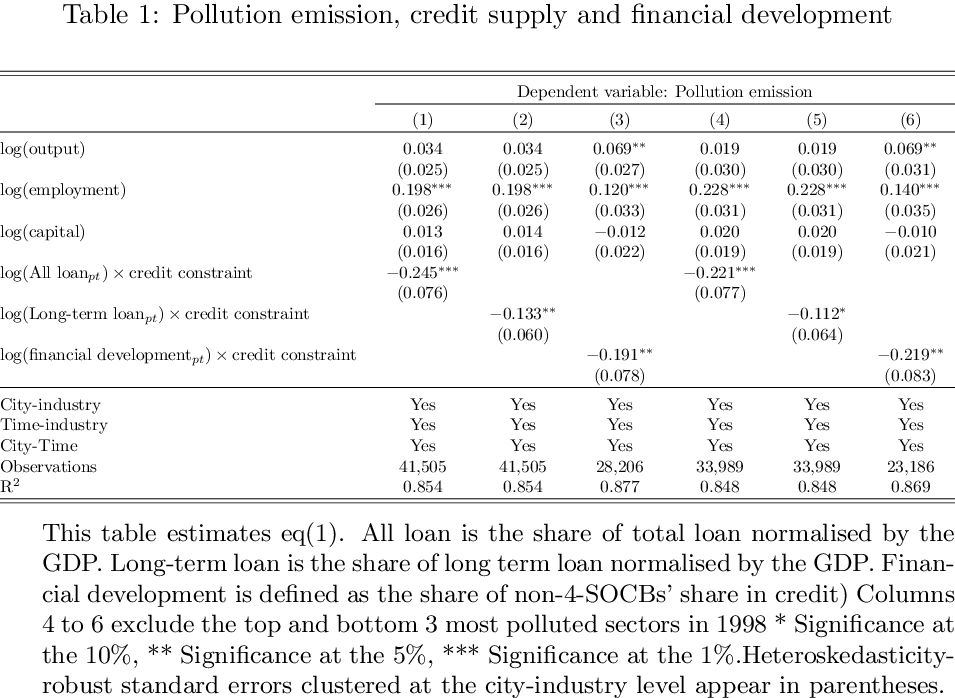

In [42]:
tbe1  = "This table estimates eq(1). " \
"All loan is the share of total loan normalised by the GDP. " \
"Long-term loan is the share of long term loan normalised by the GDP. " \
"Financial development is defined as the share of non-4-SOCBs' share in credit) " \
"Columns 4 to 6 exclude the top and bottom 3 most polluted sectors in 1998 " \
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%." \
"Heteroskedasticity-robust standard errors " \
"clustered at the city-industry level appear in parentheses."

multicolumn ={
    'SO2': 3,
    #'COD': 3,
    #'Waste water': 3,
}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& All Loan', 'Long term', 'Fin.Dev', 'Above', 'Below','Above', 'Below', 'Above', 'Below' ]
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

## Table 2: heterogeneous effect: SOE vs Private

City ownership are available for the following variables:

- output
- capital
- employment
- sales

**How is it constructed**

- city ownership public vs private
    - Aggregate output by ownership and city
    - A given city will have SOE asset tangibility and PRIVATE asset tangibility [output, employment, capital and sales]
    - If asset tangibility SOE above Private then city is dominated by SOE

Notebook reference: https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/07_dominated_city_ownership.md

Industrial are available for the following variables:

- output
- capital
- employment
- sales

**Industrial size effect**
- Change computation large vs small industry
    - Compute the median (percentile) within a city taking all firms
    - Compute the median (percentile) within a city-industry taking all firms within the industry
    - For instance, Shanghai has 3 sectors, compute the median for Shanghai, and 3 median for each sector
    

Notebook reference: https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/08_dominated_industry_ownership.md

### SO2

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
### CITY DOMINATED
t_0 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(
               dominated_output_soe_c == TRUE & tso2 > 500),
            exactDOF = TRUE)

t_1 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(
               dominated_output_soe_c == FALSE & tso2 > 500),
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply_long_term) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(
               dominated_output_soe_c == TRUE & tso2 > 500),
            exactDOF = TRUE)

t_3 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply_long_term) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(
               dominated_output_soe_c == FALSE & tso2 > 500),
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(fin_dev) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_final%>% filter(
               dominated_output_soe_c == TRUE & tso2 > 500),
            exactDOF = TRUE)

t_5 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(fin_dev) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_final%>% filter(
               dominated_output_soe_c == FALSE & tso2 > 500),
            exactDOF = TRUE)
dep <- "Dependent variable: Pollution emission"
fe1 <- list(
    c("City-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Time-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("City-Time", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Pollution emission, credit supply and financial development, City dominated public/private",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the city-industry level appear in parentheses."\
"All loan is the share of total loan normalised by the GDP. " \
"Long-term loan is the share of long term loan normalised by the GDP. " \
"Financial development is defined as the share of non-4-SOCBs' share in credit) " \
"Column 4 to 9 splits cities based on the presence of SOEs firms. Above means the total output produced by "\
"SOEs firms exceed the output of private firms. " \
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 3,
    'COD': 3,
    'Waste water': 3,
}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Above', 'Below','Above', 'Below', 'Above', 'Below' ]
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

## Table 3: heterogeneous effect: Domestic vs Foreign

### SO2

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
### CITY DOMINATED
t_0 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(
               dominated_output_for_c == TRUE & tso2 > 500),
            exactDOF = TRUE)

t_1 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(
               dominated_output_for_c == FALSE & tso2 > 500),
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply_long_term) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(
               dominated_output_for_c == TRUE & tso2 > 500),
            exactDOF = TRUE)

t_3 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply_long_term) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(
               dominated_output_for_c == FALSE & tso2 > 500),
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(fin_dev) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_final%>% filter(
               dominated_output_for_c == TRUE & tso2 > 500),
            exactDOF = TRUE)

t_5 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(fin_dev) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_final%>% filter(
               dominated_output_for_c == FALSE & tso2 > 500),
            exactDOF = TRUE)
dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("City-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Time-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("City-Time", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="SO2 emission reduction, credit supply and financial development, City dominated Domestic/Foreign",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the city-industry level appear in parentheses."\
"All loan is the share of total loan normalised by the GDP. " \
"Long-term loan is the share of long term loan normalised by the GDP. " \
"Financial development is defined as the share of non-4-SOCBs' share in credit) " \
"Column 4 to 9 splits cities based on the presence of SOEs firms. Above means the total output produced by "\
"SOEs firms exceed the output of private firms. " \
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 3,
    'COD': 3,
    'Waste water': 3,
}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Above', 'Below','Above', 'Below', 'Above', 'Below' ]
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

## Table 4: heterogeneous effect: Large vs Small

### SO2

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
var <- .75
df_temp_true = df_final %>% 
    mutate(filter_ = str_extract(dominated_output_i, paste0("(?<=", var, "\\=)(.*?)(?=\\,)")))%>%
    filter(filter_ == 'false') ### fix do not change
df_temp_false = df_final %>% 
    mutate(filter_ = str_extract(dominated_output_i, paste0("(?<=", var, "\\=)(.*?)(?=\\,)"))) %>%
    filter(filter_ == 'true') ### fix do not change
### CITY DOMINATED
t_0 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_temp_true%>% filter(
                tso2 > 500),
            exactDOF = TRUE)

t_1 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_temp_false%>% filter(
                tso2 > 500),
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply_long_term) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_temp_true%>% filter(
                tso2 > 500),
            exactDOF = TRUE)

t_3 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply_long_term) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_temp_false%>% filter(
               tso2 > 500),
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(fin_dev) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_temp_true%>% filter(
                tso2 > 500),
            exactDOF = TRUE)

t_5 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(fin_dev) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_temp_false%>% filter(
                tso2 > 500),
            exactDOF = TRUE)
dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("City-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Time-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("City-Time", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="SO2 emission reduction, credit supply and financial development, Industry dominated Large vs Small",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the city-industry level appear in parentheses."\
"All loan is the share of total loan normalised by the GDP. " \
"Long-term loan is the share of long term loan normalised by the GDP. " \
"Financial development is defined as the share of non-4-SOCBs' share in credit) " \
"Column 4 to 9 splits cities based on the presence of SOEs firms. Above means the total output produced by "\
"SOEs firms exceed the output of private firms. " \
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 3,
    'COD': 3,
    'Waste water': 3,
}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Above', 'Below','Above', 'Below', 'Above', 'Below' ]
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

## Table 5: TCZ & SPZ policy

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
t_0 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(tso2 > 500 & tcz == 0),
            exactDOF = TRUE)

t_1 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply) * credit_constraint 
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(tso2 > 500 & tcz == 1),
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply_long_term) * credit_constraint
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(tso2 > 500 & tcz == 0),
            exactDOF = TRUE)

t_3 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(lag_credit_supply_long_term) * credit_constraint 
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr + ind2, df_final%>% filter(tso2 > 500 & tcz == 1),
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(fin_dev) * credit_constraint 
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_final%>% filter(tso2 > 500 & tcz == 0),
            exactDOF = TRUE)

t_5 <- felm(log(tso2) ~  
            log(output) + log(employment) + log(capital) + 
            log(fin_dev) * credit_constraint 
           |  fe_c_i + fe_t_i + fe_c_t|0 | geocode4_corr+ ind2, df_final%>% filter(tso2 > 500 & tcz == 1),
            exactDOF = TRUE)
dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("City-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Time-industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("City-Time", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="SO2 emission reduction, credit supply and financial development",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the city-industry level appear in parentheses."\
"All loan is the share of total loan normalised by the GDP. " \
"Long-term loan is the share of long term loan normalised by the GDP. " \
"Financial development is defined as the share of non-4-SOCBs' share in credit) " \
"Column 4 to 9 splits cities based on the presence of SOEs firms. Above means the total output produced by "\
"SOEs firms exceed the output of private firms. " \
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 3,
    'COD': 3,
    'Waste water': 3,
}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& No TCZ', 'TCZ','No TCZ', 'TCZ', 'No TCZ', 'TCZ' ]
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

## Table 6: Environmental policy and financial development

$$
\begin{aligned}
\text{$S O 2_{p k t}=\alpha$ Financial Dependencies $_{k} \times \text{credit supply}_{pt} \times \text{policy mandate}_p +\mu_{p t}+\gamma_{k t}+\delta_{p k}+\epsilon_{p k t}$}
\end{aligned}
$$

Environmental policy and financial development:  Aggregate at the province-industry-year level
1. Evaluate the effect of credit constraint in provinces with stringent environmental policy
  1. SO2
    1. credit_constraint * target_reduction_so2_p * period
    2. lag_credit_supply*credit_constraint * target_reduction_so2_p * period
  2. ~COD~
      1. ~credit_constraint * target_reduction_co2_p * period~
      2. ~lag_credit_supply*credit_constraint * target_reduction_co2_p * period~

Message 
* Capital within financially constrained industries have been relocated toward investment less harming for the environment (i.e. lower emission) in province with stringent environmental policy
* One channel is the increase of the credit access → more loan availability in constraint industry

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

### Province level

In [ ]:
%get path table
t_0 <- felm(log(tso2) ~  
            credit_constraint * target_reduction_so2_p * period
           |  fe_p_i + fe_t_i + fe_p_t|0 | province_en +ind2, df_agg%>% 
             filter( target_reduction_so2_p > 0),
            exactDOF = TRUE)

t_1 <- felm(log(tso2) ~  
            log(lag_credit_supply)*credit_constraint * target_reduction_so2_p * period
           |  fe_p_i + fe_t_i + fe_p_t|0 | province_en +ind2, df_agg%>% 
             filter( target_reduction_so2_p > 0),
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~  
            log(lag_credit_supply_long_term)*credit_constraint * target_reduction_so2_p * period
           |  fe_p_i + fe_t_i + fe_p_t|0 | province_en +ind2, df_agg%>% 
             filter( target_reduction_so2_p > 0),
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("Province-industry", "Yes", "Yes", "Yes"),
    c("Time-industry", "Yes", "Yes", "Yes", "Yes"),
    c("Province-Time", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2
),
    title="SO2 emission reduction, credit constraint and policy mandate",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']

reorder = {
    6:0,
    3:5
    #0:2,
    #1:3
    #9:2,
    #0:3,
    #6:5
    #14:5
}

lb.beautify(table_number = table_nb,
            reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

## Table 7: parallel trend

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
t_0 <- felm(log(tso2) ~  
           credit_constraint * target_reduction_so2_p * year
           |  fe_p_i + fe_t_i + fe_p_t|0 | province_en +ind2, df_agg%>% 
             filter( target_reduction_so2_p > 0),
            exactDOF = TRUE)


dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("Province-industry", "Yes"),
    c("Province-industry", "Yes"),
    c("Province-Time", "Yes")
             )

table_1 <- go_latex(list(
    t_0
),
    title="parallel trend",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the product level appear inparentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
            folder = folder,
            parallel = True)

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_report

In [ ]:
name_json = 'parameters_ETL_pollution_credit_constraint.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)
notebookname = "00_credit_supply.ipynb"

In [ ]:
create_report.create_report(extension = "html", keep_code = False, notebookname =  notebookname)

In [ ]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          #os.path.join(str(Path(path).parent), "00_download_data_from"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)